# Design Under Uncertainty

*Purpose*: 


## Setup


In [1]:
import grama as gr
import pandas as pd
DF = gr.Intention()
%matplotlib inline

# Uncertainty in Engineering Systems


In [2]:
from grama.models import make_prlc_rand
md_circuit = make_prlc_rand()


## Perturbed Design Variables

(Manufacturing variability means real parts will tend to be slightly different from designed parts.)


In the previous exercise e-grama07-fit-multivar we saw a model for a circuit's performance. That system exhibited variability in its *realized component values*; we could pick the nominal (designed) component values `R, L, C`, but manufacturing variability would give rise to different as-made component values `Rr, Lr, Cr`.

As a reminder, let's take a look at designed `C` and realized `Cr` values of the circuit capacitance.


In [3]:
# NOTE: No need to edit; run and inspect
(
    md_circuit
    >> gr.ev_sample(n=1e3, df_det="nom")
    
    >> gr.tf_summarize(
        C=gr.mean(DF.C),
        Cr_lo=gr.quant(DF.Cr, p=0.05),
        Cr_mu=gr.mean(DF.Cr),
        Cr_up=gr.quant(DF.Cr, p=0.95),
    )
)

eval_sample() is rounding n...


,C,Cr_lo,Cr_mu,Cr_up
0,50.0005,42.656272,64.630406,87.399969


The results above indicate that the designed capicitance was around `50`, but values as low as `42.2` and as high as `87.8` occur too.


### __qX__ Interpret the following density plot

The nominal value for `Design 1` is `x = 0.5`, while the nominal value for `Design 2` is `x = 1.5`. However, parts manufactured according to both designs are subject to manufacturing variability, as depicted by the following densities. Answer the questions under *observations* below.


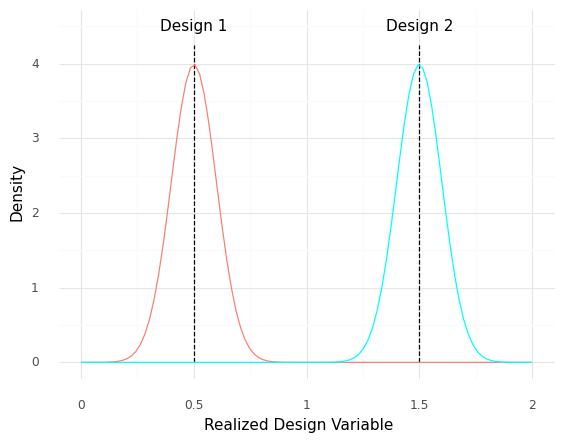

<ggplot: (8771914005920)>

In [4]:
mg_1 = gr.marg_mom("norm", mean=+0.5, sd=0.1)
mg_2 = gr.marg_mom("norm", mean=+1.5, sd=0.1)

(
    gr.df_make(x=gr.linspace(0, +2, 100))
    >> gr.tf_mutate(
        y_1=mg_1.d(DF.x),
        y_2=mg_2.d(DF.x),
    )
    
    >> gr.ggplot(gr.aes("x"))
    + gr.annotate("segment", x=+0.5, xend=+0.5, y=0, yend=4.25, linetype="dashed")
    + gr.annotate(
        "text",
        x=+0.5, y=4.5,
        label="Design 1",
    )
    + gr.annotate("segment", x=+1.5, xend=+1.5, y=0, yend=4.25, linetype="dashed")
    + gr.annotate(
        "text",
        x=+1.5, y=4.5,
        label="Design 2",
    )
    + gr.geom_line(gr.aes(y="y_1"), color="salmon")
    + gr.geom_line(gr.aes(y="y_2"), color="cyan")
    
    + gr.theme_minimal()
    + gr.labs(
        x="Realized Design Variable",
        y="Density"
    )
)

*Observations*

For the following questions, assume that you can measure `x` with *perfect* accuracy.

<!-- task-begin -->
- Suppose you have a part with `x == 0.61`. Which design specification was this most likely manufactured according to?
  - (Your response here)
- Suppose you selected a random part of `Design 2` off the manufacturing line and found that `x == 1.40`. Would you be surprised by this?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- Suppose you have a part with `x == 0.61`. Which design specification was this most likely manufactured according to?
  - `Design 1`
- Suppose you selected a random part of `Design 2` off the manufacturing line and found that `x == 1.40`. Would you be surprised by this?
  - Unsurprising; we can see that `x == 1.40` is well-within the distribution around the nominal `Design 2` value.
<!-- solution-end -->

### __qX__ Set up a perturbation model

Implement a model for a perturbed design variable $x_r$ following

$$x_r = x + \Delta x$$

where $\Delta x$ is normally distributed with mean $\mu = 0$ and standard deviation $\sigma = 0.1$.

*Hint*: The previous exercises `e-grama06-fit-univar` and `e-grama07-fit-multivar` cover how to model an uncertain quantity.


In [5]:
## TASK: Implement the model for x_r stated above

md_dx = (
    gr.Model("Perturbation")
    >> gr.cp_vec_function(
# task-begin
        ## TODO: Implement a function for the perturbation
# task-end
# solution-begin
        fun=lambda df: gr.df_make(
            x_r=df.x + df.dx,
        ),
# solution-end
        var=["x", "dx"],
        out=["x_r"],
    )
    >> gr.cp_bounds(x=(-1, +1))
# task-begin
    ## TODO: Use compositions to model the uncertainty of dx
# task-end
# solution-begin
    >> gr.cp_marginals(
        dx=gr.marg_mom("norm", mean=0, sd=0.1),
    )
    >> gr.cp_copula_independence()
# solution-end
)

## NOTE: Use this to check your work
gr.eval_sample(md_dx, n=1, df_det="nom")
    
assert \
    'dx' in md_dx.density.marginals.keys(), \
    'No density for dx'
assert \
    md_dx.density.marginals['dx'].d_param['loc'] == 0., \
    "Density for dx has wrong mean"
assert \
    md_dx.density.marginals['dx'].d_param['scale'] == 0.1, \
    "Density for dx has wrong standard deviation"
    

## Uncertainty Propagation

Often, we model engineering outcomes *deterministically*; assuming certain inputs $x$ are known exactly, we produce a predictable output value $y$ based on a mathematical model $y = f(x)$.

For example, we've previously looked at a model for the buckling strength of a rectangular plate

$$\sigma_{cr} = k_{cr} \frac{\pi^2 E}{12 (1 - \mu^2)} \left(\frac{t}{b}\right)^2.$$

This is a *deterministic* model for the buckling strength $\sigma_{cr}$ that depends on the plate geometry, such as the plate thickness $t$.


However, if the input values cannot be controlled exactly, it may be more appropriate to think of the model as having *perturbed* inputs $x_r = x + \Delta x$. With perturbed inputs, the output is no longer precisely known, but is now subject to *uncertainty propagation*. We can think of this mathematically as 

$$y(x) = f(x_r) = f(x + \Delta x).$$

Where the input that the function "sees" is the perturbed input, rather than the deterministic input. This leads to uncertainty in the output $y$---the uncertainty *propagates* from the input to the output.

The following images depict uncertainty propagation schematically. First, let's look at a linear function $f(x)$.

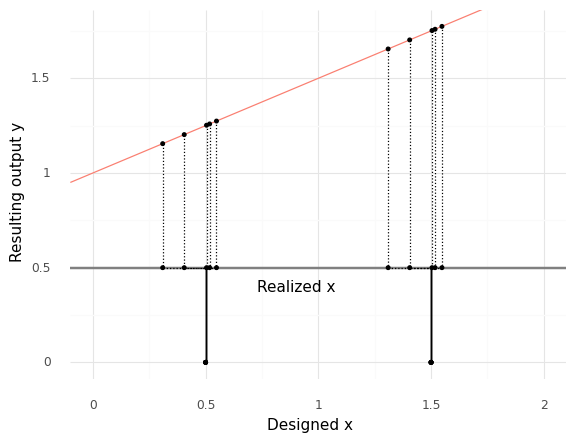

<ggplot: (8771892479223)>

In [6]:
# NOTE: No need to edit; this illustrates uncertainty propagation
md_line = (
    md_dx
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(y=0.5*df.x_r + 1),
        var=["x_r"],
        out=["y"],
    )
)

y_baseboard = 0.5

(
    md_line
    >> gr.ev_sample(
        n=5,
        df_det=gr.df_make(x=(0.5, 1.5)),
        seed=101,
    )
    
    >> gr.ggplot(gr.aes("x_r", "y"))
    + gr.geom_hline(yintercept=y_baseboard, color="grey", size=1)
    + gr.geom_abline(intercept=1, slope=0.5, color="salmon")
    
    + gr.geom_segment(gr.aes(xend="x_r", yend=y_baseboard), linetype="dotted")
    + gr.geom_segment(gr.aes(xend="x", y=y_baseboard, yend=y_baseboard), linetype="dotted")
    + gr.geom_segment(gr.aes(x="x", xend="x", y=0, yend=y_baseboard))
    + gr.geom_point(size=1)
    + gr.geom_point(gr.aes(y=y_baseboard), size=1)
    + gr.geom_point(gr.aes(x="x", y=0), size=1)
    + gr.annotate(
        "text",
        x=0.9,
        y=y_baseboard-0.1,
        label="Realized x",
    )
    
    + gr.scale_x_continuous(limits=(0, 2))
    + gr.theme_minimal()
    + gr.labs(
        x="Designed x",
        y="Resulting output y",
    )
)

Here we have designed values of $x$ at $x = 0.5$ and $x = 1.5$. However, perturbations lead to variability in the realized values $x_r$, which in turn lead to variability in the output $y$.

The variability in $y$ is roughly the same at both designed values $x$. However, a different function can lead to quite different results.


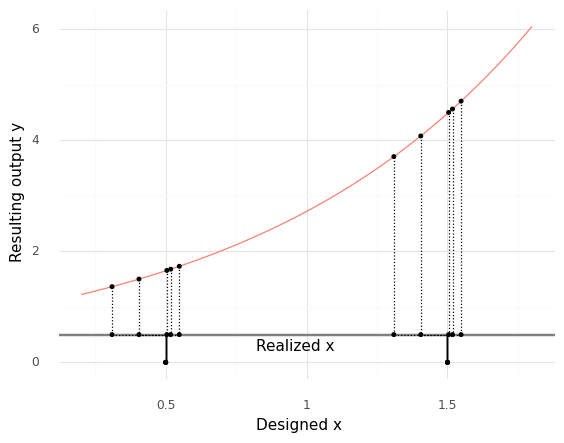

<ggplot: (8771913992930)>

In [7]:
# NOTE: No need to edit; this illustrates uncertainty propagation
md_exp = (
    md_dx
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(y=gr.exp(df.x_r)),
        var=["x_r"],
        out=["y"],
    )
)

y_baseboard = 0.5

(
    md_exp
    >> gr.ev_sample(
        n=5,
        df_det=gr.df_make(x=(0.5, 1.5)),
        seed=101,
    )
    
    >> gr.ggplot(gr.aes("x_r", "y"))
    + gr.geom_hline(yintercept=y_baseboard, color="grey", size=1)
    + gr.geom_line(
        data=md_exp
        >> gr.ev_nominal(df_det=gr.df_make(x=gr.linspace(0.2, 1.8, 100))),
        mapping=gr.aes("x"),
        color="salmon",
    )
    
    + gr.geom_segment(gr.aes(xend="x_r", yend=y_baseboard), linetype="dotted")
    + gr.geom_segment(gr.aes(xend="x", y=y_baseboard, yend=y_baseboard), linetype="dotted")
    + gr.geom_segment(gr.aes(x="x", xend="x", y=0, yend=y_baseboard))
    + gr.geom_point(size=1)
    + gr.geom_point(gr.aes(y=y_baseboard), size=1)
    + gr.geom_point(gr.aes(x="x", y=0), size=1)
    + gr.annotate(
        "text",
        x=0.96,
        y=y_baseboard-0.2,
        label="Realized x",
    )
    
    + gr.theme_minimal()
    + gr.labs(
        x="Designed x",
        y="Resulting output y",
    )
)

Once again we see variability in the realized values. However, note that the variability in the realized output `y` 


### __qX__ Do a sweep with propagated uncertainty

Use your perturbation model `md_dx` to study how variability propagates through the function

$$y(x) = f(x_r) = x_r^4.$$

Sweep the design variable $x$ from at least $0.1$ to $1.0$, and make sure to use a sufficient number of observations in your random sample. Answer the questions under *observations* below.


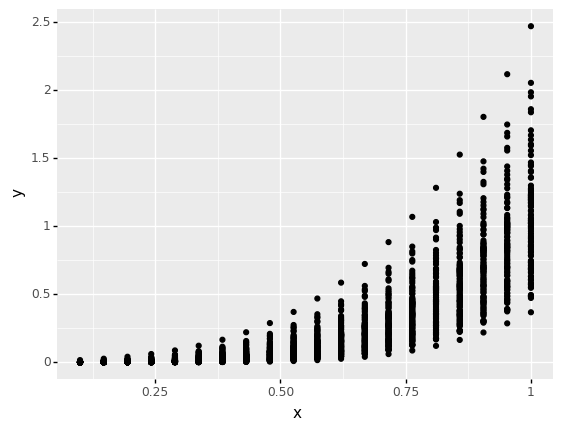

<ggplot: (8771914032975)>

In [8]:
## TASK: Evaluate a sweep with with propagated uncertainty
df_dx = (
    md_dx
    # NOTE: No need to edit; this composes the output function
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(y=df.x_r**4),
        var=["x_r"],
        out=["y"],
    )
    
# task-begin
    ## TODO: Evaluate a random sample
# task-end
# solution-begin
    >> gr.ev_sample(
        n=100,
        df_det=gr.df_make(x=gr.linspace(0.1, 1.0, 20)),
    )
# solution-end
)

## NOTE: Use this to check your work
assert \
    isinstance(df_dx, pd.DataFrame), \
    "df_dx is not a DataFrame; make sure to evaluate md_dx"
assert \
    df_dx.x.min() <= 0.1, \
    "Make sure to sweep to a value as low as x == 0.1"
assert \
    df_dx.x.max() >= 1.0, \
    "Make sure to sweep to a value as high as x == 1.0"
assert \
    len(set(df_dx.x)) >= 10, \
    "Make sure to use a sufficient number of points in your sweep"
assert \
    len(set(df_dx.dx)) >= 100, \
    "Make sure to use a sufficient number of points in your sample"

# Visualize
(
    df_dx
    >> gr.ggplot(gr.aes("x", "y"))
    + gr.geom_point()
)

*Observations*

For the following questions, assume that you can measure `x` with *perfect* accuracy.

<!-- task-begin -->
- What does the horizontal axis in the plot above represent: The designed value of `x` or the realized value of `x`?
  - (Your response here)
- Why is there variability in `y`?
  - (Your response here)
- Where (along the horizontal axis) is the variability in `y` large? Where is it small?
  - (Your response here)
- What about the underlying function `y = f(x)` explains the trends in variability you noted above?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- What does the horizontal axis in the plot above represent: The designed value of `x` or the realized value of `x`?
  - The horizontal axis in the plot above represents the designed value of `x`.
- Why is there variability in `y`?
  - There is variability in `y` because we are visualizing the designed value of `x`, while the realized value `x_r`
- Where (along the horizontal axis) is the variability in `y` large? Where is it small?
  - The variability is smallest at small values of $x$, and largest at large values of $x$.
- What about the underlying function `y = f(x)` explains the trends in variability you noted above?
  - Since the function is $y = x_r^4$, variability in $x_r$ is amplified by the function. You can think of this in terms of the derivative $\frac{dy}{dx_r} = 4 x_r^3 = 4 (x + \Delta x)^3$; note that larger values of the designed value lead to a larger slope in $y$.
<!-- solution-end -->

## Summarizing variability

Visualizing variability with a scatterplot is a good first-step, but there are more effective ways to *summarize* variability.


### __qX__ Summarize variability across a sweep

Answer the questions under *observations* below.


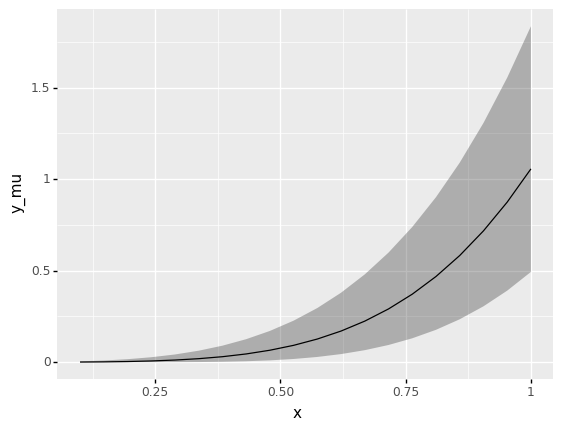

<ggplot: (8771914032918)>

In [9]:
df_dx_summary = (
    df_dx
# task-begin
    ## TODO: Summarize the result value `y` at each value of the
    ## designed value `x`
# task-end
# solution-begin
    >> gr.tf_group_by(DF.x)
    >> gr.tf_summarize(
        y_lo=gr.quant(DF.y, p=0.05),
        y_mu=gr.mean(DF.y),
        y_up=gr.quant(DF.y, p=0.95),
    )
# solution-end
    ## NOTE: Clean up the grouping
    >> gr.tf_ungroup()
)

## NOTE: No need to edit; use this to check your work
assert \
    set(df_dx.x) == set(df_dx_summary.x), \
    "Incorrect grouping for df_dx_summary"
assert \
    "y_lo" in df_dx_summary.columns, \
    "Make sure to compute a lower quantile y_lo"
assert \
    "y_up" in df_dx_summary.columns, \
    "Make sure to compute an upper quantile y_up"
# Check the quantiles
df_dx_check = (
    df_dx
    >> gr.tf_left_join(df_dx_summary, by="x")
    >> gr.tf_filter(DF.x == gr.min(DF.x))
    >> gr.tf_summarize(
        p_lo=gr.pr(DF.y <= DF.y_lo),
        p_up=gr.pr(DF.y <= DF.y_up),
    )
)
assert \
    abs(df_dx_check.p_lo[0] - 0.05) < 1e-3, \
    "Lower quantile value is incorrect"
assert \
    abs(df_dx_check.p_up[0] - 0.95) < 1e-3, \
    "Upper quantile value is incorrect"

(
    df_dx_summary
    >> gr.ggplot(gr.aes("x"))
    + gr.geom_ribbon(
        mapping=gr.aes(ymin="y_lo", ymax="y_up"),
        alpha=1/3,
    )
    + gr.geom_line(gr.aes(y="y_mu"))
)

*Observations*

*Note*: This plot uses `geom_ribbon()`, which takes the aesthetics `ymin` and `ymax`. A ribbon is a useful way to visualize a region bounded by lower and upper values, such as quantiles!

<!-- task-begin -->
- Contrast this plot with the scatterplot from qX: What can you see in this ribbon plot that is harder to see in the scatterplot?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- Contrast this plot with the scatterplot from qX: What can you see in this ribbon plot that is harder to see in the scatterplot?
  - Some examples: We can see the mean trend quite clearly, while the mean trend is harder to judge by eye in the scatterplot. We can also see particular quantiles; if we wanted to make decisions based on the middle 90% of the data, these would be ideal bounds to use. If we wanted to use a different fraction of the data (say, 99%) we could adjust the quantiles (say, `0.005` and `0.995`).
<!-- solution-end -->


## Real vs Error

Generally speaking: Real variability will propagate through a system without our intervention. Error will only propagate into a system through our design decisions.


TODO Illustrative example


### __qX__ (TODO Illustrative task)


```{admonition} Separating real and erroneous variability
Most physical scenarios will exhibit both real and erroneous variability. Only careful data collection combined with sound statistical analysis can seprate these two sources of variability.

While this sort of statistical analysis is beyond the scope of the present course, if you'd like to learn more, try looking into "ANOVA", in particular "repeated measures ANOVA".
```

# Designing for uncertainty


## Robustness


In [10]:
## NOTE: No need to edit; this sets up a model with
## a perturbed input and a complex output function
md_poly = (
    gr.Model("Polynomial")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            xp=df.x + df.e
        ),
        var=["x", "e"],
        out=["xp"],
        name="Additive input noise"
    )
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            y=(df.xp + 0.6) 
             *(df.xp + 0.4) 
             *(df.xp - 0.65)
             *(df.xp - 0.55)
             *13.5 * (1 + gr.exp(8.0 * df.xp))
        ),
        var=["xp"],
        out=["y"],
        name="Function to minimize"
    )
    >> gr.cp_bounds(x=(-1, +1))
    >> gr.cp_marginals(e=gr.marg_mom("norm", mean=0, sd=0.03))
    >> gr.cp_copula_independence()
)

### __qX__ Interpret this plot


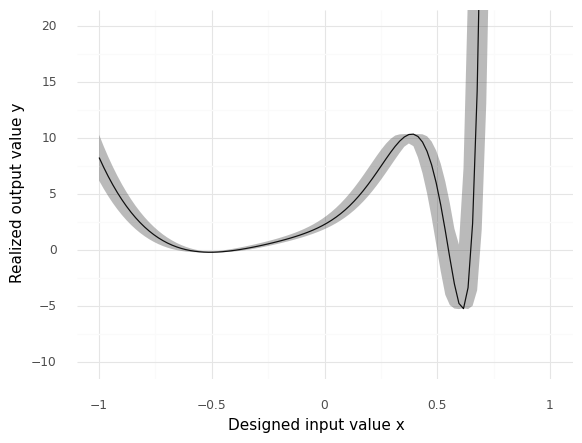

<ggplot: (8771876242234)>

In [11]:
## NOTE: No need to edit; run and inspect
# Evaluate model without uncertainty
df_poly_nom = (
    md_poly
    >> gr.ev_nominal(
        df_det=gr.df_make(x=gr.linspace(-1, +1, 100)),
    )
)

# Evaluate with uncertainty, take quantiles
df_poly_mc = (
    md_poly
    >> gr.ev_sample(
        df_det=gr.df_make(x=gr.linspace(-1, +1, 100)),
        n=40,
        seed=101,
    )
    >> gr.tf_group_by("x")
    >> gr.tf_summarize(
        y_lo=gr.quant(DF.y, p=0.05),
        y_mu=gr.median(DF.y),
        y_up=gr.quant(DF.y, p=0.95),
    )
    >> gr.tf_ungroup()
)

# Visualize
(
    df_poly_mc
    >> gr.tf_mutate(source="Quantiles")
    >> gr.ggplot(gr.aes("x"))
    + gr.geom_line(
        data=df_poly_nom
        >> gr.tf_mutate(source="Nominal"),
        mapping=gr.aes(y="y"),
    )
    + gr.geom_ribbon(
        mapping=gr.aes(ymin="y_lo", ymax="y_up"),
        alpha=1/3,
    )
    
    + gr.scale_y_continuous(breaks=(-10, -5, 0, +5, +10, +15, +20))
    + gr.coord_cartesian(ylim=(-10, 20))
    + gr.theme_minimal()
    + gr.guides(color=None)
    + gr.labs(
        x="Designed input value x",
        y="Realized output value y",
    )
)

*Observations*

For this example, *lower* values of `y` are better.

<!-- task-begin -->
- *Approximately*, what is the lowest value `y` value the `Nominal` curve achieves across the values of `x` depicted above?
  - (Your response here)
- *Approimately*, what is the value of `y` for the `Nominal` curve at `x = -0.5`?
  - (Your response here)
- Note the spread between the `Quantiles` at $x \approx 0.6$. *Approximately* what range of `y` values would you expect to result from releated manufacturing at $x \approx 0.6$?
  - (Your response here)
- Note the spread between the `Quantiles` at $x \approx -0.5$. *Approximately* what range of `y` values would you expect to result from releated manufacturing at $x \approx -0.5$?
  - (Your response here)
- Suppose you plan to manufacture many parts according to this process, test all specimens, and choose the 5%. Which design (value of `x`) would you pick, and why?
  - (Your response here)
- Suppose you plan to manufacture many parts according to this process, all of which must work at an acceptable level. Which design (value of `x`) would you pick, and why?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
<!-- solution-end -->

## Reliability


## Setting Variability Targets
